Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.



<IPython.core.display.Javascript object>


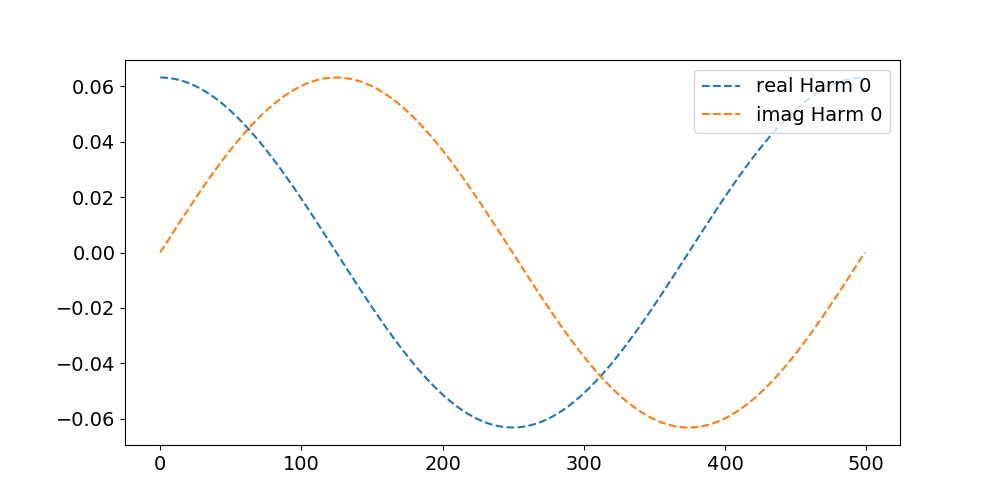

In [1]:
%matplotlib notebook
import numpy as np
from scipy import sparse, linalg
import matplotlib.pyplot as plt
from scipy.misc import derivative
#from scipy import optimize
import sys
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from amfe.frequency_module.frequency import cos_bases_for_MHBM, create_Z_matrix, linear_harmonic_force, hbm_complex_bases
from amfe.optimize import optimize
from ipywidgets import interact
from matplotlib.animation import FuncAnimation, writers
import matplotlib.animation as animation


plt.rcParams.update({'font.size': 14})


#B = cos_bases_for_MHBM(1,number_of_harm=1,static=False)
nH = 1
n_points = 500
q = hbm_complex_bases(1,number_of_harm=nH,n_points=n_points,static=False,normalized=False)

fig = plt.figure(figsize=(10,5))
for i in range(q.shape[1]):
#for i in range(2):
    plt.plot(q[:,i].real,'--',label='real Harm ' + str(i))
    plt.plot(q[:,i].imag,'--',label='imag Harm ' + str(i))
 
plt.legend(loc='upper right')
plt.show()

<IPython.core.display.Javascript object>


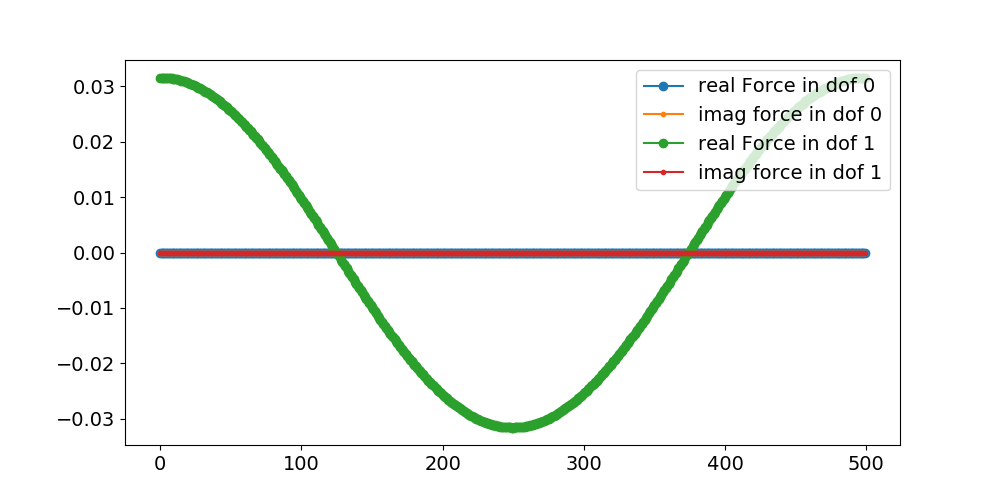

In [2]:
amplitude_dof_2 = 0.5
Bc = np.array([0,1]) # dof section ma
P = np.array([0.0,amplitude_dof_2], dtype = np.complex)
beta = 0.05
m1 = 1.0
m2 = m1
k1 = 1.0
k2 = k1
c1 = 0.05
c2 = c1

K = np.array([[k1+k2, -k2],
              [-k2,k2]])

M = np.array([[m1,0.0],
              [0.0,m2]])

C = np.array([[c1+c2,-c2],
              [-c2,c2]])

n_dofs = K.shape[0] 
I = np.eye(n_dofs)
I_harm = np.eye(nH)
#Q = np.kron(q ,[1]*nH)
Q = np.kron(I,q[:,0])
for i in range(1,nH):
    Q = np.concatenate([Q,np.kron(I,q[:,i])])
Q = Q.T

P_aug = list(0*P)*nH
P_aug[0:n_dofs] = list(P)
P_aug = np.array(P_aug)
Bc_aug = sparse.kron(I_harm,Bc)
#fl = linear_harmonic_force(P, f0 = 1, n_points=50, cos=True)
fl = Q.dot(P_aug).real
#fl = np.kron(I.toarray().dot(P),q).real

fig = plt.figure(figsize=(10,5))
for i in range(int(fl.shape[0]/n_points)):
    plt.plot(fl[i*n_points:(i+1)*n_points].real,'o-',label='real Force in dof ' + str(i))
    plt.plot(fl[i*n_points:(i+1)*n_points].imag,'.-',label='imag force in dof ' + str(i))
 
plt.legend(loc='upper right')
plt.show()

<IPython.core.display.Javascript object>


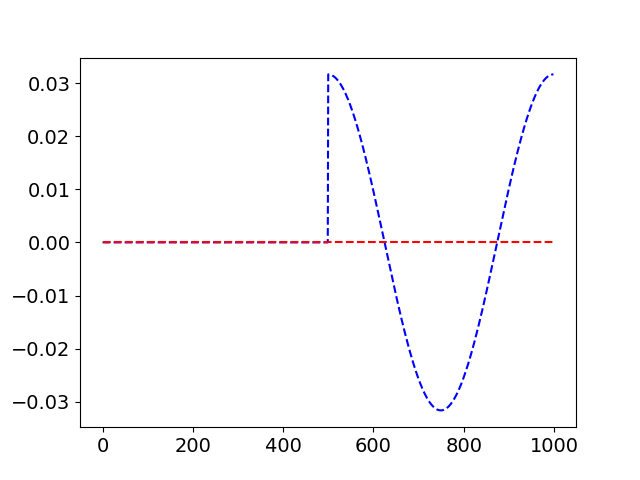

In [3]:
plt.figure()
plt.plot(fl.real,'b--')
plt.plot(fl.imag,'r--')

(1000, 2)


<IPython.core.display.Javascript object>


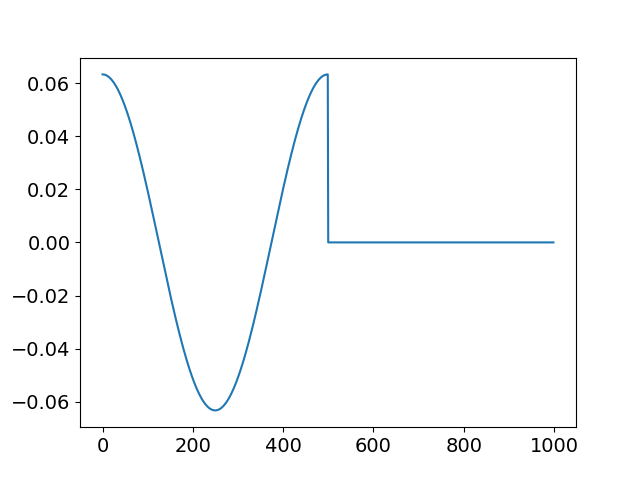

In [4]:
print(Q.shape)

plt.figure()
plt.plot(Q[:,0].real)

In [5]:
fl_ = Q.conj().T.dot(fl) # force in frequency domain
fl_

array([0.   +0.0000000e+00j, 0.501-6.2934548e-18j])

In [6]:
fl_ = Q.conj().T.dot(fl) # force in frequency domain
fl_ = Bc_aug.T.dot(Bc_aug.dot(fl_))

fnl = lambda u : beta*(u**3)
fnl_ = lambda u_ : Bc_aug.T.dot(Bc_aug.dot(Q.conj().T.dot(fnl(Q.dot(u_).real)) - fl_))
Z = lambda w :create_Z_matrix(K,C,M,f0= w/(2.0*np.pi),nH=nH, static=False)
#Z = lambda w: np.array([-(w)**2*M + 1J*(w)*C + K]) 
R = lambda u_, w : Z(w).dot(u_) + fnl_(u_)


In [7]:
p = np.linspace(0.01,4,500)
Ru = lambda f : lambda u_ : R(u_,f)
#x0 = np.array([0],dtype=np.complex)
x0 = np.array([0]*n_dofs*nH,dtype=np.complex)
x_list = []
f_list = []
for f in p:
    opt_obj = optimize.root(Ru(f),x0=x0,tol=1.0E-12)
    x_opt = opt_obj.x
    #x0 = x_opt
    if opt_obj.success:
        x_list.append(x_opt)
        f_list.append(f)
    

<IPython.core.display.Javascript object>


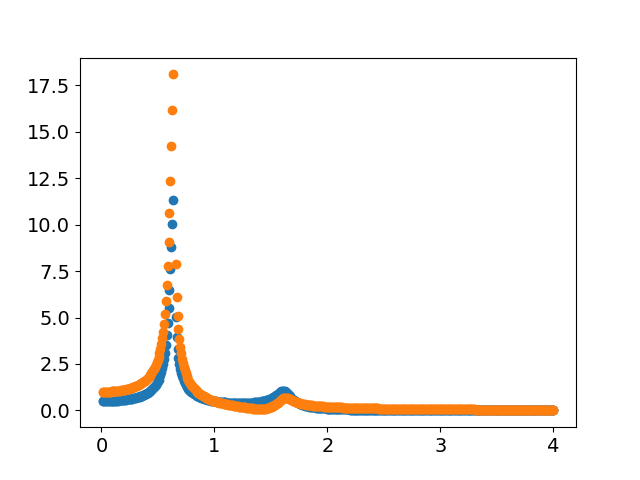

In [8]:
plt.figure()
plt.plot(f_list, np.abs(x_list),'o')

In [9]:
val, vec = linalg.eig(K,M)

In [10]:
np.sqrt(1/val)

array([0.61803399+0.j, 1.61803399+0.j])

In [11]:
fnl(opt_obj.x)

array([ 5.45867586e-10+4.82818774e-10j, -1.88574105e-06-8.73844929e-08j])

In [12]:
f = 0.25
opt_obj = optimize.root(Ru(f),x0=x0,tol=1.0E-12)
opt_obj.x

array([0.61321372-0.00934769j, 1.18811488-0.01763224j])

In [13]:
fl_

array([0.   +0.0000000e+00j, 0.501-6.2934548e-18j])

In [14]:
np.diag(Q.conj().T.dot(Q).real)[0]

2.0000000000000013